# Loading the previous chapter

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [5]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [6]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [7]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [9]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [10]:

val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

# Accuracy

In [11]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.8016129032258065

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8016129032258065

Let's try different thresholds for prediction.

In [14]:
thresholds = np.linspace(0, 1, 11)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [15]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.05 0.501
0.10 0.595
0.15 0.640
0.20 0.690
0.25 0.730
0.30 0.755
0.35 0.767
0.40 0.782
0.45 0.795
0.50 0.802
0.55 0.790
0.60 0.790
0.65 0.788
0.70 0.774
0.75 0.752
0.80 0.742
0.85 0.739
0.90 0.739
0.95 0.739
1.00 0.739


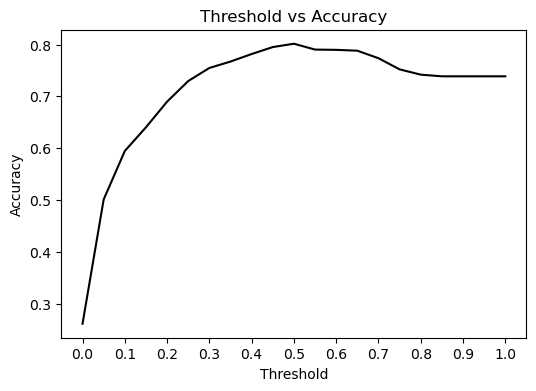

In [16]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

Threshold of 0.5 is actually the best to predict correctly.

However, if we look at the threshold at 1, the model still have around 70% of accuracy. 
This is beacuase the dataset alreadly has more people (~70%) who did not churn than those who churn. 

This is called, "class imbalance."

In [21]:
sum(y_val == 0)/len(y_val)

0.7387096774193549

# Confusion Table

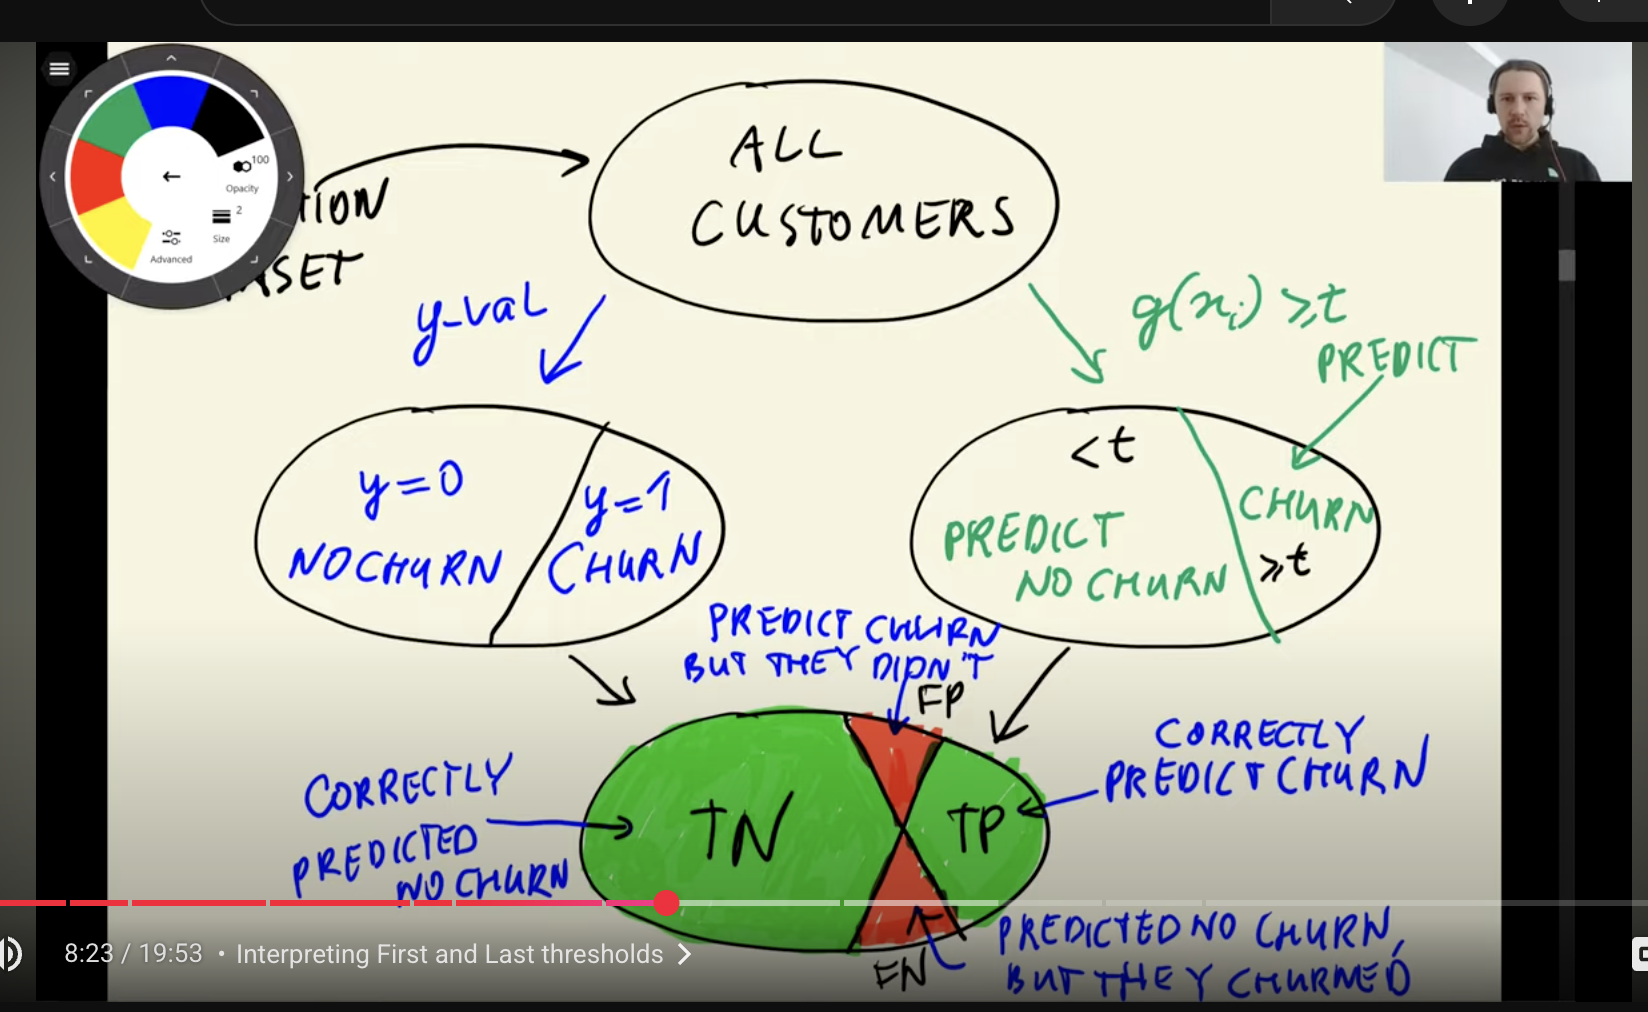

In [27]:
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

In [29]:
confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table

array([[1202,  172],
       [ 197,  289]])

In [30]:
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

Costomers that we falsely predicted as churn or not churn are thoes who our promotion, e.g. discounts for retention, fail to increase our profit. 

Now, we have a much clear picture of the accuracy rate, which is account by 65% of true positive and 15% of true nagative. 

# Precision and Recall

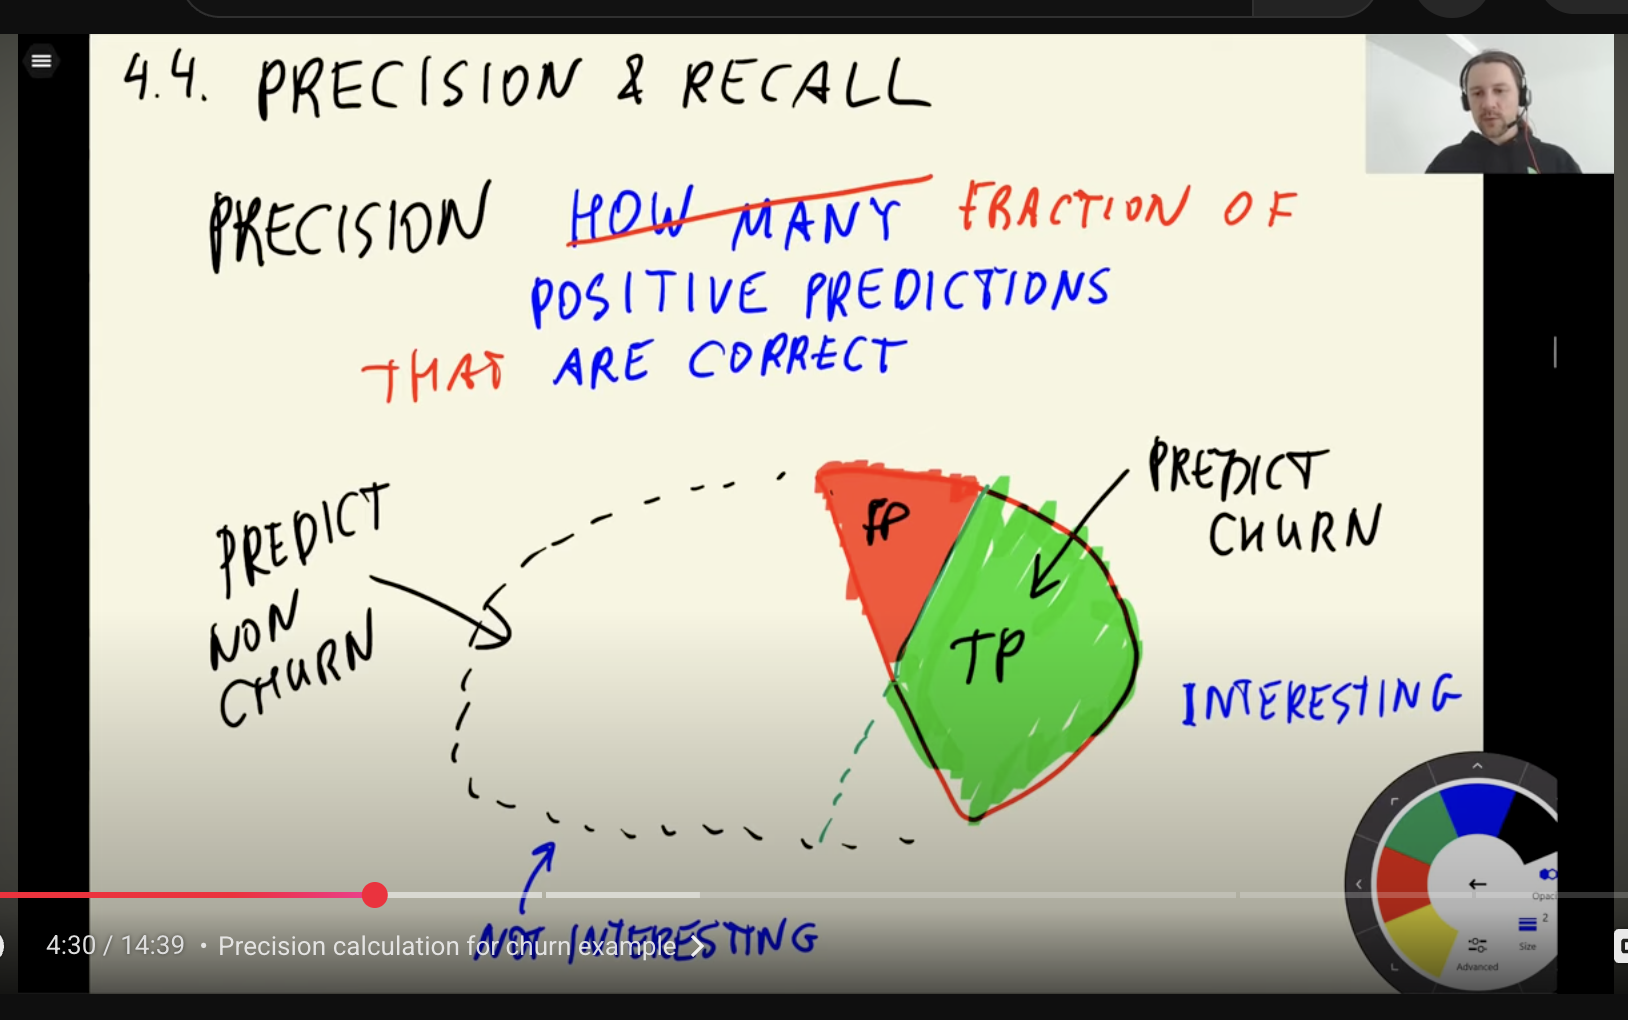

Presicion is "the fraction of positive predictions that are correct."

In [35]:
precision = true_positive / (true_positive + false_positive)
precision, 1- precision

(0.6268980477223427, 0.3731019522776573)

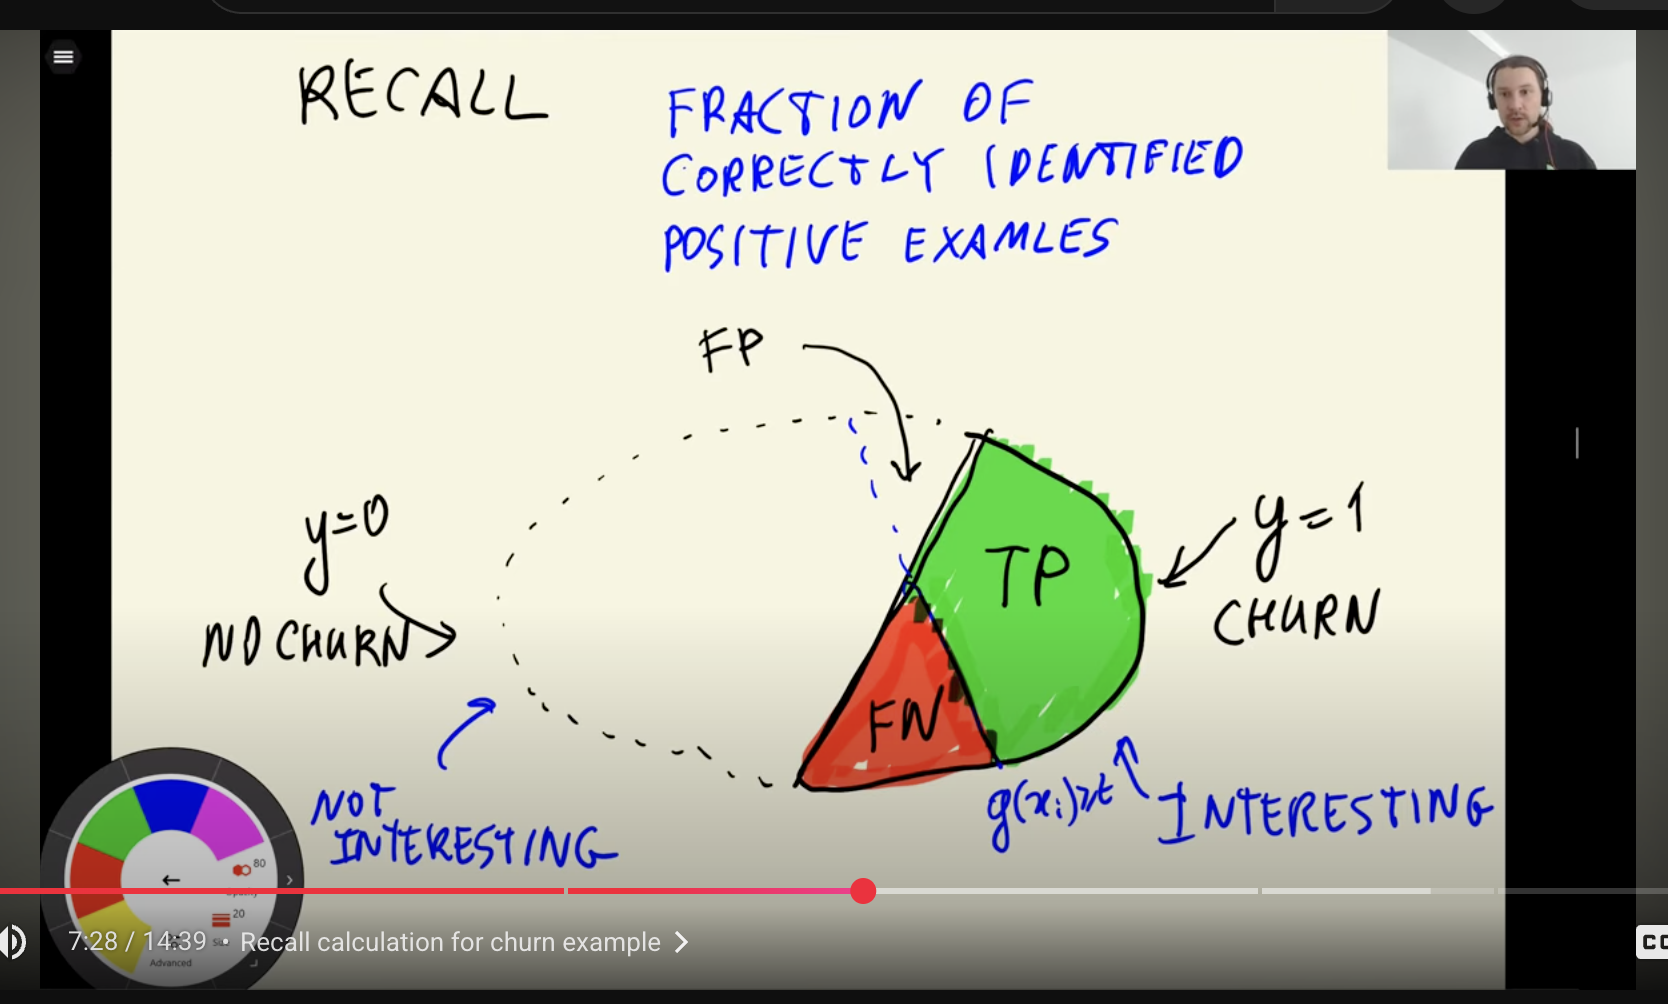

Recall is "the fraction of correctly identified positive examples."

In [36]:
recall = true_positive / (true_positive + false_negative)
recall, 1 - recall

(0.5946502057613169, 0.4053497942386831)

Although accuraccy is 80%, presicion and recall tell us that in the model's prediction, there are 37% of costomers are falsely predicted as churn and 46% of costomers are falsely predicted as not churn. 

# ROC and AUC

ROC: Receiver Operating Characteristic

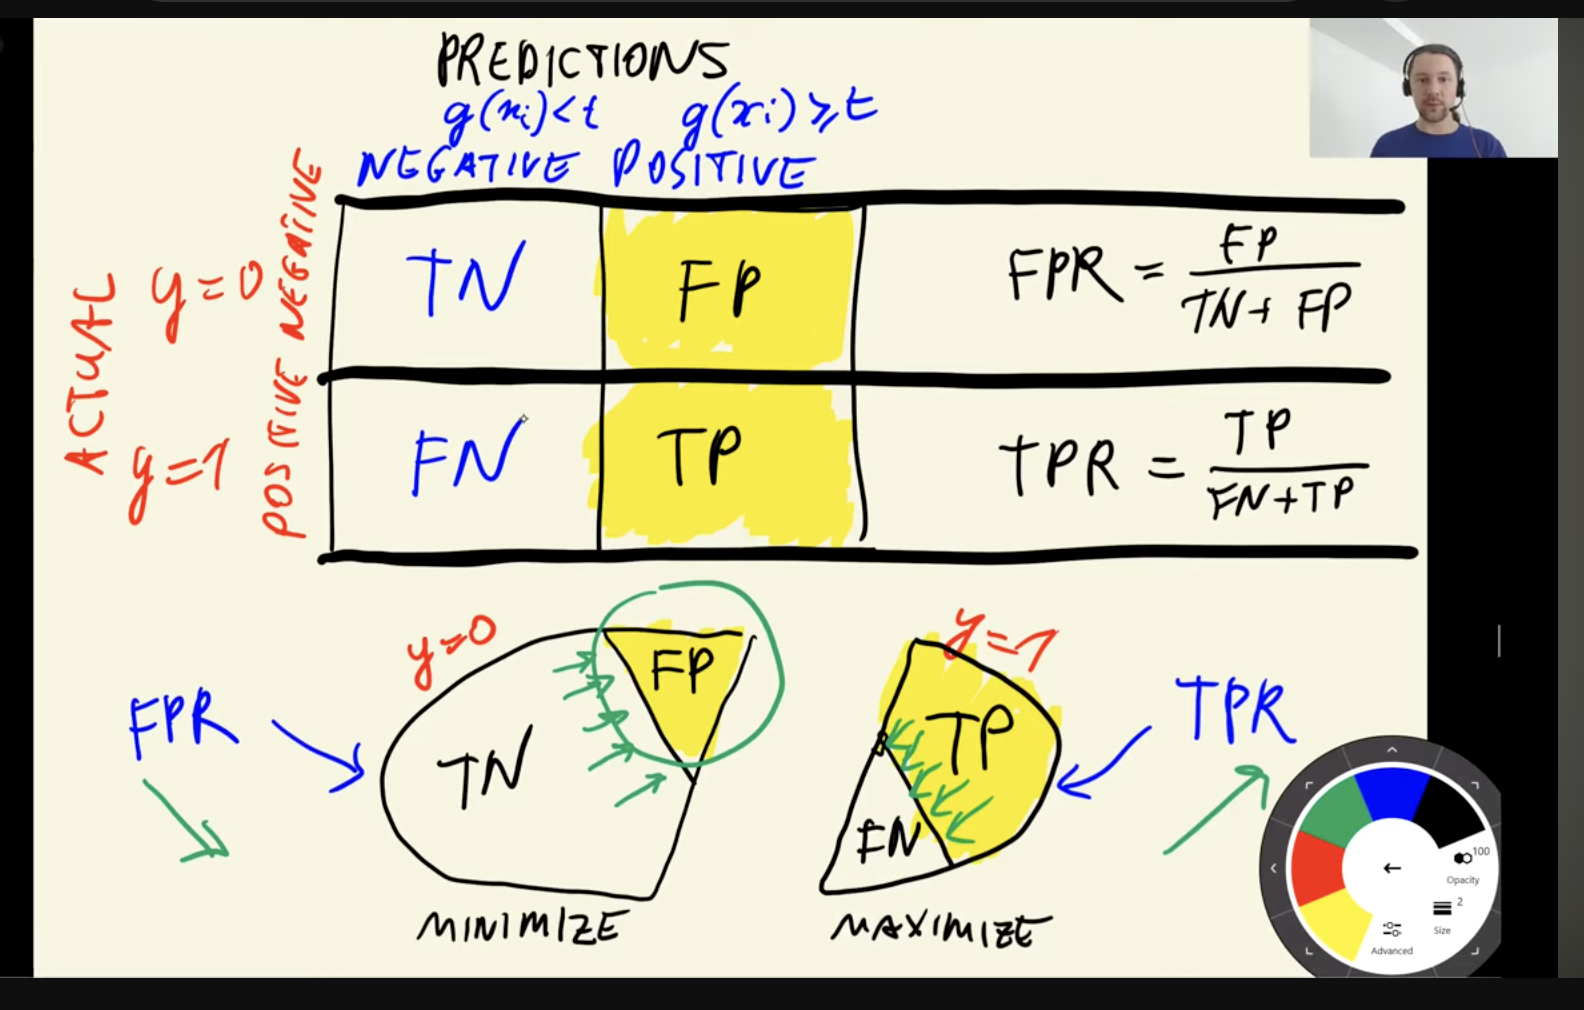

In [34]:
# TPR and FPR

tpr = true_positive / (true_positive + false_positive)
fpr = true_positive / (true_positive + false_negative)
tpr, fpr

(0.6268980477223427, 0.5946502057613169)

## ROC curves

In [37]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [38]:
df_scores[::10]


threshold   tp    fp   fn    tn
0          0.0  486  1374    0     0
10         0.1  458   726   28   648
20         0.2  421   512   65   862
30         0.3  380   350  106  1024
40         0.4  337   257  149  1117
50         0.5  289   172  197  1202
60         0.6  200   105  286  1269
70         0.7   99    34  387  1340
80         0.8    7     1  479  1373
90         0.9    0     0  486  1374
100        1.0    0     0  486  1374

In [39]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [40]:
df_scores[::10]


threshold   tp    fp   fn    tn       tpr       fpr
0          0.0  486  1374    0     0  1.000000  1.000000
10         0.1  458   726   28   648  0.942387  0.528384
20         0.2  421   512   65   862  0.866255  0.372635
30         0.3  380   350  106  1024  0.781893  0.254731
40         0.4  337   257  149  1117  0.693416  0.187045
50         0.5  289   172  197  1202  0.594650  0.125182
60         0.6  200   105  286  1269  0.411523  0.076419
70         0.7   99    34  387  1340  0.203704  0.024745
80         0.8    7     1  479  1373  0.014403  0.000728
90         0.9    0     0  486  1374  0.000000  0.000000
100        1.0    0     0  486  1374  0.000000  0.000000

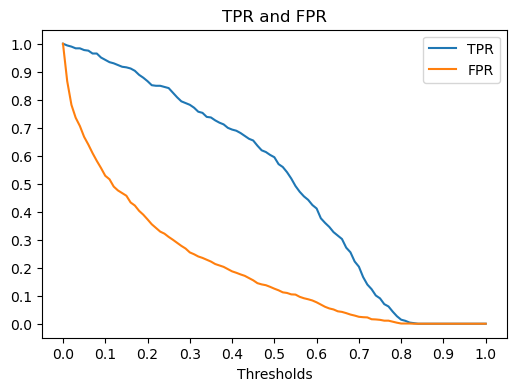

In [42]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

plt.show()

## Random model

In [45]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [46]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [48]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

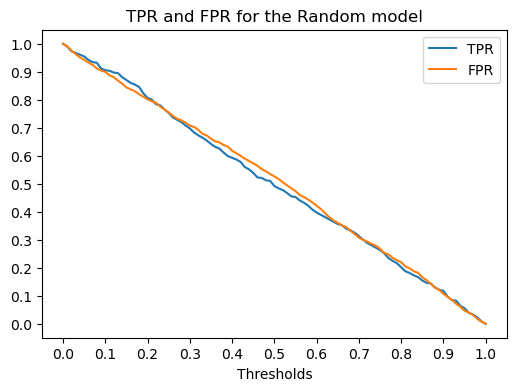

In [61]:
plt.figure(figsize=(6, 4))

plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the Random model')

plt.show()

## Ideal Model

In [51]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1374, 486)

In [53]:
# arrange a list of 0 and 1 where the first 1374 numbers are 0 and the rest are 1.
y_ideal = np.repeat([0, 1], [num_neg, num_pos]) 

In [55]:
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

In [58]:
1 - y_val.mean()

0.7387096774193549

In [60]:
((y_pred_ideal  >= 0.739) == y_ideal).mean()

1.0

In [56]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)
df_ideal[::10]

threshold   tp    fp   fn    tn       tpr       fpr
0          0.0  486  1374    0     0  1.000000  1.000000
10         0.1  486  1188    0   186  1.000000  0.864629
20         0.2  486  1002    0   372  1.000000  0.729258
30         0.3  486   816    0   558  1.000000  0.593886
40         0.4  486   630    0   744  1.000000  0.458515
50         0.5  486   444    0   930  1.000000  0.323144
60         0.6  486   258    0  1116  1.000000  0.187773
70         0.7  486    72    0  1302  1.000000  0.052402
80         0.8  372     0  114  1374  0.765432  0.000000
90         0.9  186     0  300  1374  0.382716  0.000000
100        1.0    1     0  485  1374  0.002058  0.000000

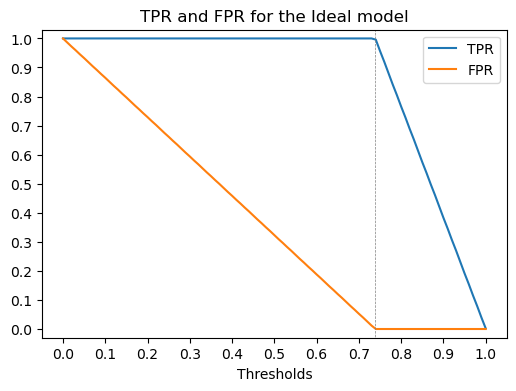

In [63]:
plt.figure(figsize=(6, 4))

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the Ideal model')

# plt.savefig('04_fpr_tpr_plot_ideal.svg')

plt.show()

## Putting everything together

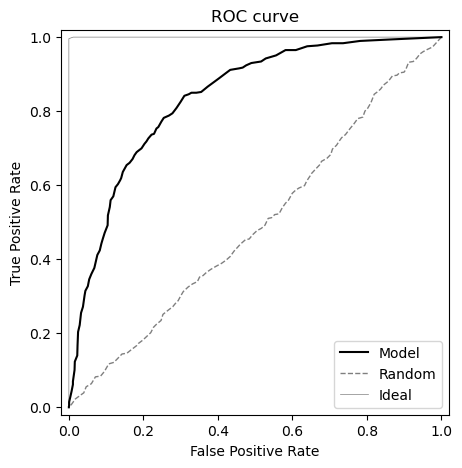

In [64]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='black', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='black', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve_with_baselines.svg')

plt.show()

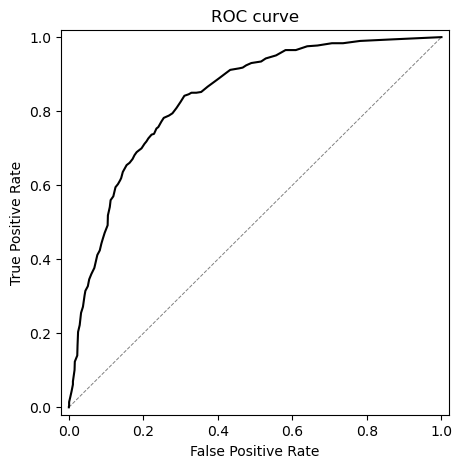

In [65]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve.svg')

plt.show()

Noted: every dots on the curve represent the combination of FPR and TPR with a specific threshold. 

# Plotting ROC Curve with Scikit-Learn

In [66]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [67]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)


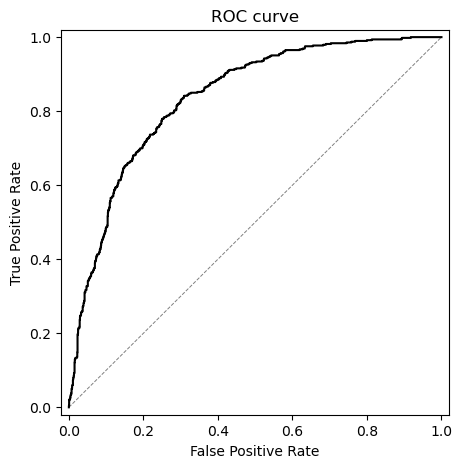

In [68]:
plt.figure(figsize=(5, 5))

#Our model
plt.plot(fpr, tpr, color='black')

#Random model
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

# AUC

Area Under (the ROC) Curve

In [70]:
auc(fpr, tpr) #sklean metrics

0.8363381374257972

In [73]:
auc(df_scores.fpr, df_scores.tpr) #dataframe metrics with 101 thresholds

0.8359001084215382

Interpretation of AUC: the probability that a randomly chosen positive example ranks higher than a randomly chosen negative example

In [74]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

np.random.seed(1)
neg_choice = np.random.randint(low=0, high=len(neg), size=10000)
pos_choice = np.random.randint(low=0, high=len(pos), size=10000)
(pos[pos_choice] > neg[neg_choice]).mean()

0.8356

# K-Fold Cross-Validation

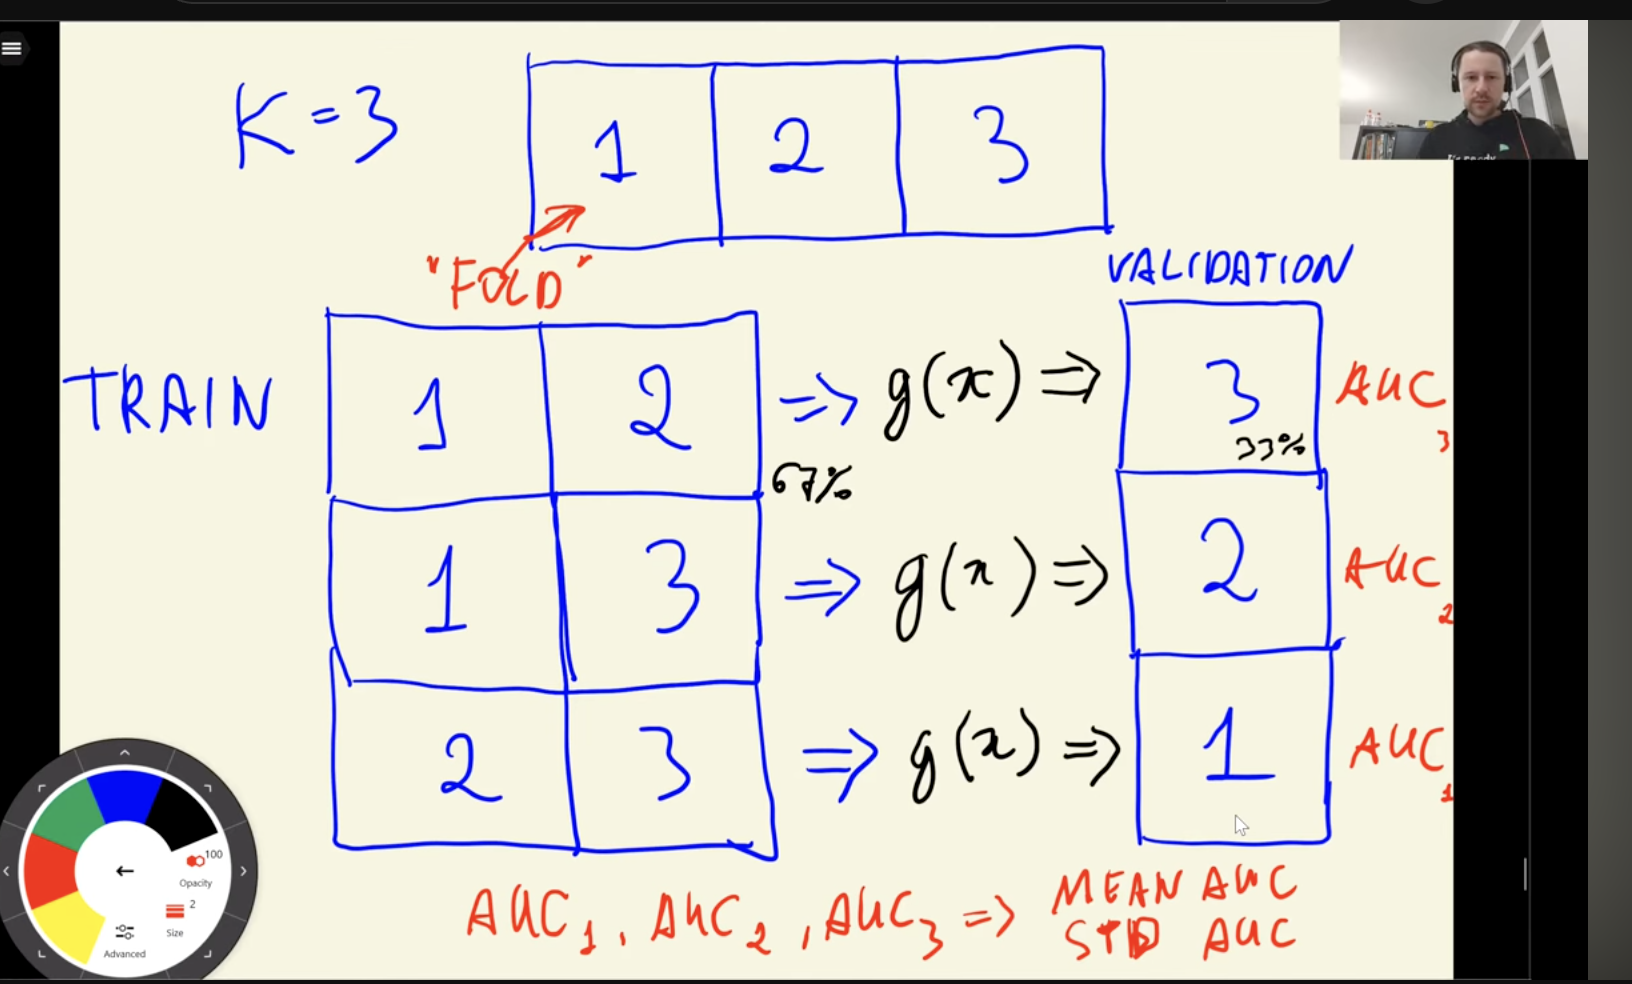

In [75]:
def train(df_train, y_train):
    cat = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X_train = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [78]:
from sklearn.model_selection import KFold


In [79]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)


In [81]:
from sklearn.metrics import roc_auc_score


In [82]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.churn.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [83]:
np.array(aucs).round(3)


array([0.849, 0.842, 0.859, 0.833, 0.824, 0.841, 0.844, 0.822, 0.845,
       0.861])

In [84]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))


auc = 0.842 ± 0.012


Parameter tuning

In [85]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [86]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.840 ± 0.009
C=0.1, auc = 0.841 ± 0.007
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


FUll retrain on the test dataset using the ideal parameter (0.1). 

In [90]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=0.1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858
